In [1]:
%matplotlib inline

# 0. General note

* `pymatgen` works only with `py35`

* This notebook shows how to make an XRD plot using `pymatgen`.

* This also aims to show how to read `CIF` files, convert them to `JCPDS`.

# 1. General setup

In [2]:
import pymatgen as mg
from pymatgen import Lattice, Structure
from pymatgen.analysis.diffraction.xrd import XRDCalculator
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Import `ds_jcpds` which is used by `peakpo`.  Because of this, if you move this notebook out of its original directory, this notebook needs modification to function properly.

In [3]:
import sys
sys.path.insert(0, '../peakpo')
import ds_jcpds

In [4]:
fn_cif = "../jcpds_from_cif/CIFs/corundum_Kirfel1990.cif"
fn_jcpds = '../jcpds_from_cif/Al2O3.jcpds'
comments_jcpds = "corundum by Kirfel 1990"

In [5]:
k0 = 160.
k0p = 4.00
alpha = 3.16e-5

In [6]:
wl_xray = 0.3344
xrange = (0,40)

# 2. Read CIF of Bridgmanite

The `cif` file below was downloaded from American mineralogist crystal structure database.

In [7]:
material = mg.Structure.from_file(fn_cif)

# 3. Get some contents from CIF

In [8]:
print('Unit-cell volume = ', material.volume)
print('Density = ', material.density)
print('Chemical formula = ', material.formula)

Unit-cell volume =  254.524259692
Density =  3.991226963516955 g
Chemical formula =  Al12 O18


# 4. Get lattice parameters

In [9]:
lattice = material.lattice
print('Lattice parameters = ', lattice.a, lattice.b, lattice.c, \
      lattice.alpha, lattice.beta, lattice.gamma)
crystal_system = SpacegroupAnalyzer(material).get_crystal_system()
print(crystal_system)

Lattice parameters =  4.757 4.757 12.9877 90.0 90.0 120.0
trigonal


# 5. Get diffraction pattern

In [10]:
c = XRDCalculator(wavelength=wl_xray)
pattern = c.get_xrd_data(material, two_theta_range = xrange)

## 5.1. Extract twotheta, d-sp, int, hkl

In [11]:
d_lines = []
for values in pattern:
    hkl_key = values[2].keys()
    hkl_txt = str(hkl_key)[12:-3].split(",")
    # print(hkl_txt[0], hkl_txt[1], hkl_txt[-1])
    d_lines.append([values[0], values[3], values[1], \
                        int(hkl_txt[0]), int(hkl_txt[1]), int(hkl_txt[-1]) ])

diff_lines = np.asarray(d_lines)
print(diff_lines)

[[  5.50982446e+00   3.47871214e+00   4.78556021e+01   1.00000000e+00
    0.00000000e+00   2.00000000e+00]
 [  7.51871844e+00   2.55009722e+00   7.97457632e+01   1.00000000e+00
    0.00000000e+00   4.00000000e+00]
 [  8.06202386e+00   2.37850000e+00   3.72574125e+01   2.00000000e+00
   -1.00000000e+00   0.00000000e+00]
 ..., 
 [  3.96871028e+01   4.92557143e-01   1.18076820e+00   4.00000000e+00
   -2.00000000e+00   2.40000000e+01]
 [  3.98302664e+01   4.90858219e-01   8.50345008e-03   8.00000000e+00
    0.00000000e+00   8.00000000e+00]
 [  3.98888823e+01   4.90166221e-01   1.38637524e-01   8.00000000e+00
   -4.00000000e+00   1.50000000e+01]]


## 5.2. Table output

In [12]:
table = pd.DataFrame(data = diff_lines,    # values
    columns=['Two Theta', 'd-spacing', 'intensity', 'h', 'k', 'l'])  # 1st row as the column names
table.head()

,Two Theta,d-spacing,intensity,h,k,l
0,5.509824,3.478712,47.855602,1.0,0.0,2.0
1,7.518718,2.550097,79.745763,1.0,0.0,4.0
2,8.062024,2.378500,37.257413,2.0,-1.0,0.0
3,8.860143,2.164617,0.470187,0.0,0.0,6.0
4,9.200940,2.084604,88.646843,2.0,-1.0,3.0


## 5.3. Plot peak positions generated from pymatgen

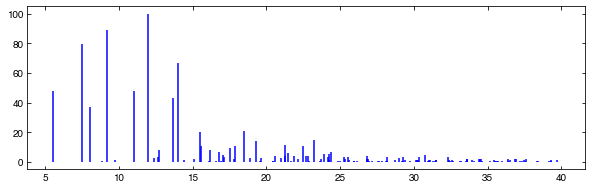

In [13]:
f = plt.figure(figsize=(10,3))
plt.vlines(diff_lines[:,0], 0., diff_lines[:,2], color='b');

# 6. Convert to JCPDS

Setup an `jcpds` object from a `cif` file

In [14]:
material_jcpds = ds_jcpds.JCPDS()
material_jcpds.set_from_cif(fn_cif, k0, k0p, \
                      thermal_expansion=alpha, two_theta_range=xrange)

Calculate diffraction pattern at a pressure.

In [15]:
material_jcpds.cal_dsp(pressure = 100.)
dl = material_jcpds.get_DiffractionLines()
tth, inten = material_jcpds.get_tthVSint(wl_xray)

no symmetry is given


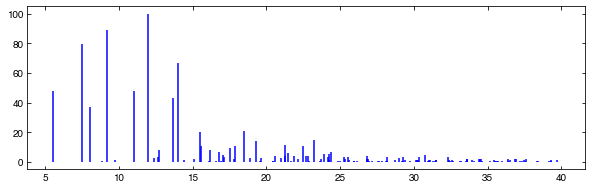

In [16]:
f = plt.figure(figsize=(10,3))
plt.vlines(diff_lines[:,0], 0., diff_lines[:,2], color='b')
plt.vlines(tth, 0., inten, color = 'r');

# 7. Save to a JCPDS file

In [17]:
material_jcpds.write_to_file(fn_jcpds, comments=comments_jcpds)

# 8. Read back the written JCPDS for test

In [18]:
material_test = ds_jcpds.JCPDS(filename = fn_jcpds)

Calculate a pattern at a pressure

In [19]:
material_test.cal_dsp(pressure = 10.)
material_test.get_DiffractionLines()
tth, inten = material_test.get_tthVSint(wl_xray)

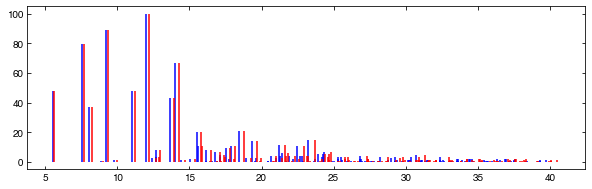

In [20]:
f = plt.figure(figsize=(10,3))
plt.vlines(diff_lines[:,0], 0., diff_lines[:,2], color='b')
plt.vlines(tth, 0., inten, color = 'r');